In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
from ipywidgets import FloatSlider, interactive

In [2]:
method_l = [
    "maxcorr", 
    "mincorr", 
    "maxlinreg", 
    "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [3]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results8_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["maxcorr"]["corrs"]]

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["maxcorr"]["corrs"][network].values()))) # god this is a hack

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [4]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [5]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [6]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [7]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_large_cased_0
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000 -0.265463   0.648543  -0.205262
mincorr   -0.265463  1.000000   0.176683   0.841959
maxlinreg  0.648543  0.176683   1.000000   0.267479
minlinreg -0.205262  0.841959   0.267479   1.000000
bert_large_cased_1
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000 -0.017500   0.966645   0.214578
mincorr   -0.017500  1.000000   0.035135   0.745353
maxlinreg  0.966645  0.035135   1.000000   0.277683
minlinreg  0.214578  0.745353   0.277683   1.000000
bert_large_cased_2
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000  0.115626   0.977872   0.433956
mincorr    0.115626  1.000000   0.131451   0.741138
maxlinreg  0.977872  0.131451   1.000000   0.450647
minlinreg  0.433956  0.741138   0.450647   1.000000
bert_large_cased_3
            maxcorr   mincorr  maxlinreg  minlinreg
maxcorr    1.000000  0.098159   0.980597   0.347944
mincorr    0.098159  1.000000   0.121334

### Distributions

In [8]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_large_cased_0:

maxcorr

maxcounts
bert_large_cased_1                  981
bert_base_cased_0                    40
calypso_transformer_6_512_base_0      2
openai_transformer_2                  1
dtype: int64

mincounts
xlnet_large_cased_23    687
elmo_4x4096_512_2        67
xlnet_large_cased_20     50
xlnet_large_cased_22     34
xlnet_large_cased_16     32
xlnet_large_cased_19     26
xlnet_large_cased_21     20
xlnet_large_cased_18     19
xlnet_large_cased_17     19
xlnet_large_cased_15     18
elmo_4x4096_512_3         9
xlnet_large_cased_13      9
xlnet_large_cased_14      4
xlnet_large_cased_12      3
bert_base_cased_8         3
xlnet_large_cased_3       2
bert_base_cased_12        2
xlnet_large_cased_9       2
xlnet_large_cased_7       2
bert_large_cased_19       2
xlnet_large_cased_1       2
elmo_4x4096_512_4         2
bert_large_cased_18       2
xlnet_large_cased_4       1
xlnet_large_cased_5       1
bert_large_cased_21       1
elmo_original_2           1
bert_large_cased_2

bert_large_cased_3    1013
bert_large_cased_1      11
dtype: int64

mincounts
xlnet_large_cased_23                564
elmo_4x4096_512_2                    61
xlnet_large_cased_22                 56
xlnet_large_cased_20                 46
xlnet_large_cased_16                 40
xlnet_large_cased_21                 39
xlnet_large_cased_15                 32
xlnet_large_cased_19                 30
xlnet_large_cased_18                 23
elmo_4x4096_512_3                    18
xlnet_large_cased_17                 16
xlnet_large_cased_14                 14
xlnet_large_cased_13                 11
xlnet_large_cased_12                  6
elmo_original_0                       5
xlnet_large_cased_11                  5
bert_large_cased_24                   5
xlnet_large_cased_7                   4
elmo_4x4096_512_0                     4
xlnet_large_cased_2                   4
elmo_4x4096_512_4                     3
bert_base_cased_12                    3
xlnet_large_cased_1                   3
xl

         max      min      med
max  1.00000  0.12954  0.23638
min  0.12954  1.00000  0.83980
med  0.23638  0.83980  1.00000

mincorr

maxcounts
bert_large_cased_5    740
bert_large_cased_3    284
dtype: int64

mincounts
xlnet_large_cased_23                583
xlnet_large_cased_22                 63
xlnet_large_cased_20                 49
elmo_4x4096_512_2                    42
xlnet_large_cased_16                 41
xlnet_large_cased_19                 33
xlnet_large_cased_15                 31
elmo_4x4096_512_3                    26
xlnet_large_cased_17                 22
xlnet_large_cased_18                 20
xlnet_large_cased_21                 18
xlnet_large_cased_14                 16
xlnet_large_cased_13                 14
xlnet_large_cased_12                  9
elmo_original_2                       6
xlnet_large_cased_11                  5
bert_base_cased_12                    5
xlnet_large_cased_7                   4
xlnet_large_cased_10                  4
elmo_original_1     

xlnet_large_cased_23                500
openai_transformer_12               427
calypso_transformer_6_512_base_0     40
elmo_4x4096_512_0                    35
elmo_original_0                      16
openai_transformer_0                  3
xlnet_large_cased_0                   3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.557477  0.755740
min  0.557477  1.000000  0.915607
med  0.755740  0.915607  1.000000

minlinreg

maxcounts
bert_large_cased_7    1023
bert_large_cased_5       1
dtype: int64

mincounts
xlnet_large_cased_23                500
openai_transformer_12               427
calypso_transformer_6_512_base_0     40
elmo_4x4096_512_0                    35
elmo_original_0                      16
openai_transformer_0                  3
xlnet_large_cased_0                   3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.557477  0.755740
min  0.557477  1.000000  0.915607
med  0.755740  0.915607  1.000000


bert_large_c

openai_transformer_12               658
xlnet_large_cased_23                287
calypso_transformer_6_512_base_0     38
elmo_4x4096_512_0                    23
elmo_original_0                      16
openai_transformer_0                  1
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.611405  0.809076
min  0.611405  1.000000  0.921400
med  0.809076  0.921400  1.000000


bert_large_cased_9:

maxcorr

maxcounts
bert_large_cased_10                 668
bert_large_cased_8                  355
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                596
elmo_4x4096_512_2                    47
elmo_4x4096_512_3                    44
xlnet_large_cased_22                 35
xlnet_large_cased_16                 27
xlnet_large_cased_20                 26
xlnet_large_cased_15                 20
elmo_original_0                      18
xlnet_large_cased_19                 16
xlnet_large

          max       min       med
max  1.000000  0.348146  0.466627
min  0.348146  1.000000  0.837983
med  0.466627  0.837983  1.000000

mincorr

maxcounts
bert_large_cased_10    655
bert_large_cased_12    369
dtype: int64

mincounts
xlnet_large_cased_23                632
xlnet_large_cased_22                 43
elmo_4x4096_512_2                    42
elmo_4x4096_512_3                    29
xlnet_large_cased_20                 27
xlnet_large_cased_16                 26
openai_transformer_0                 18
xlnet_large_cased_19                 17
xlnet_large_cased_15                 14
elmo_original_0                      14
xlnet_large_cased_17                 13
xlnet_large_cased_21                 12
openai_transformer_12                12
xlnet_large_cased_1                  11
elmo_4x4096_512_0                    10
elmo_original_2                      10
xlnet_large_cased_18                 10
openai_transformer_1                 10
xlnet_large_cased_14                  9
bert_b

openai_transformer_12               423
elmo_4x4096_512_0                   220
calypso_transformer_6_512_base_0    192
elmo_original_0                      96
xlnet_large_cased_23                 66
openai_transformer_0                 23
xlnet_large_cased_0                   4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.828221  0.906809
min  0.828221  1.000000  0.953070
med  0.906809  0.953070  1.000000

minlinreg

maxcounts
bert_large_cased_14    979
bert_large_cased_12     45
dtype: int64

mincounts
openai_transformer_12               423
elmo_4x4096_512_0                   220
calypso_transformer_6_512_base_0    192
elmo_original_0                      96
xlnet_large_cased_23                 66
openai_transformer_0                 23
xlnet_large_cased_0                   4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.828221  0.906809
min  0.828221  1.000000  0.953070
med  0.906809  0.953070  1.000000


bert_large_c

          max       min       med
max  1.000000  0.876037  0.916829
min  0.876037  1.000000  0.953752
med  0.916829  0.953752  1.000000


bert_large_cased_16:

maxcorr

maxcounts
bert_large_cased_15                 839
bert_large_cased_17                 184
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
xlnet_large_cased_23                574
elmo_original_0                      39
openai_transformer_0                 36
elmo_4x4096_512_2                    35
elmo_4x4096_512_0                    34
xlnet_large_cased_1                  32
elmo_4x4096_512_3                    31
xlnet_large_cased_22                 31
xlnet_large_cased_2                  19
openai_transformer_1                 18
openai_transformer_12                14
xlnet_large_cased_19                 13
xlnet_large_cased_21                 12
openai_transformer_2                 11
xlnet_large_cased_20                 11
elmo_original_2                      11
elmo_4x4096_512_4                    


maxcounts
bert_large_cased_19                 998
bert_large_cased_17                  24
calypso_transformer_6_512_base_0      1
bert_large_cased_20                   1
dtype: int64

mincounts
xlnet_large_cased_23                398
elmo_original_0                     100
elmo_4x4096_512_0                    60
openai_transformer_0                 57
xlnet_large_cased_1                  42
elmo_4x4096_512_2                    41
elmo_4x4096_512_3                    37
xlnet_large_cased_2                  31
openai_transformer_1                 28
openai_transformer_12                18
xlnet_large_cased_22                 17
xlnet_large_cased_0                  16
elmo_original_2                      11
bert_base_cased_0                    11
bert_base_cased_1                    10
elmo_4x4096_512_1                    10
xlnet_large_cased_21                  9
elmo_4x4096_512_4                     9
calypso_transformer_6_512_base_6      9
calypso_transformer_6_512_base_0      8
bert_

bert_large_cased_19    991
bert_large_cased_21     33
dtype: int64

mincounts
elmo_4x4096_512_0                   555
calypso_transformer_6_512_base_0    153
openai_transformer_12               122
elmo_original_0                     116
openai_transformer_0                 68
xlnet_large_cased_23                  5
openai_transformer_1                  2
xlnet_large_cased_0                   2
bert_base_cased_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.782212  0.840156
min  0.782212  1.000000  0.932865
med  0.840156  0.932865  1.000000

minlinreg

maxcounts
bert_large_cased_19    991
bert_large_cased_21     33
dtype: int64

mincounts
elmo_4x4096_512_0                   555
calypso_transformer_6_512_base_0    153
openai_transformer_12               122
elmo_original_0                     116
openai_transformer_0                 68
xlnet_large_cased_23                  5
openai_transformer_1                  2
xlnet_large_cased_0

          max       min       med
max  1.000000  0.749674  0.844592
min  0.749674  1.000000  0.924508
med  0.844592  0.924508  1.000000


bert_large_cased_23:

maxcorr

maxcounts
bert_large_cased_22    1023
bert_large_cased_24       1
dtype: int64

mincounts
xlnet_large_cased_23    345
elmo_4x4096_512_2        81
elmo_original_0          68
elmo_4x4096_512_0        58
xlnet_large_cased_2      45
                       ... 
xlnet_large_cased_4       1
bert_large_cased_8        1
bert_large_cased_6        1
bert_large_cased_3        1
bert_base_cased_4         1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.344949  0.348089
min  0.344949  1.000000  0.839074
med  0.348089  0.839074  1.000000

mincorr

maxcounts
bert_large_cased_22    1023
bert_large_cased_24       1
dtype: int64

mincounts
xlnet_large_cased_23    345
elmo_4x4096_512_2        81
elmo_original_0          68
elmo_4x4096_512_0        58
xlnet_large_cased_2      45
                  

openai_transformer_1                753
xlnet_large_cased_0                   3
elmo_4x4096_512_4                     2
elmo_original_1                       2
calypso_transformer_6_512_base_0      2
bert_large_cased_0                    2
openai_transformer_10                 1
bert_base_cased_0                     1
openai_transformer_2                  1
openai_transformer_7                  1
dtype: int64

mincounts
xlnet_large_cased_23                421
elmo_4x4096_512_2                    86
elmo_4x4096_512_3                    40
xlnet_large_cased_22                 30
xlnet_large_cased_20                 20
xlnet_large_cased_19                 13
xlnet_large_cased_15                 13
bert_base_cased_11                   12
xlnet_large_cased_18                 12
xlnet_large_cased_21                 11
bert_large_cased_22                  11
xlnet_large_cased_4                   9
elmo_original_2                       8
bert_base_cased_12                    7
elmo_original_1 

          max       min       med
max  1.000000  0.722332  0.808112
min  0.722332  1.000000  0.936885
med  0.808112  0.936885  1.000000


openai_transformer_3:

maxcorr

maxcounts
openai_transformer_4    415
openai_transformer_2    353
dtype: int64

mincounts
xlnet_large_cased_23                401
elmo_4x4096_512_2                    47
elmo_4x4096_512_3                    42
xlnet_large_cased_22                 31
xlnet_large_cased_15                 21
elmo_original_2                      21
bert_base_cased_12                   20
xlnet_large_cased_20                 20
xlnet_large_cased_13                 19
xlnet_large_cased_16                 18
bert_large_cased_24                  14
xlnet_large_cased_14                 14
xlnet_large_cased_21                 12
xlnet_large_cased_19                 11
elmo_4x4096_512_4                     9
xlnet_large_cased_17                  6
xlnet_large_cased_18                  5
calypso_transformer_6_512_base_6      5
bert_base_cased_10  

          max       min       med
max  1.000000  0.921692  0.964651
min  0.921692  1.000000  0.974210
med  0.964651  0.974210  1.000000

minlinreg

maxcounts
openai_transformer_6    756
openai_transformer_4     12
dtype: int64

mincounts
xlnet_large_cased_23                657
calypso_transformer_6_512_base_0     81
elmo_original_0                      15
elmo_4x4096_512_0                    15
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.921692  0.964651
min  0.921692  1.000000  0.974210
med  0.964651  0.974210  1.000000


openai_transformer_6:

maxcorr

maxcounts
openai_transformer_5    592
openai_transformer_7    176
dtype: int64

mincounts
xlnet_large_cased_23                411
bert_large_cased_24                  43
bert_base_cased_12                   31
xlnet_large_cased_22                 30
elmo_4x4096_512_3                    26
elmo_4x4096_512_2                    26
xlnet_large_cased_15                 19
bert_large_cased_23                

xlnet_large_cased_23                448
xlnet_large_cased_22                 30
elmo_original_0                      20
bert_large_cased_2                   13
bert_large_cased_23                  13
                                   ... 
bert_large_cased_12                   1
calypso_transformer_6_512_base_0      1
bert_large_cased_16                   1
bert_large_cased_17                   1
elmo_original_2                       1
Length: 61, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.690921  0.619396
min  0.690921  1.000000  0.874981
med  0.619396  0.874981  1.000000

maxlinreg

maxcounts
openai_transformer_9    752
openai_transformer_7     16
dtype: int64

mincounts
calypso_transformer_6_512_base_0    319
xlnet_large_cased_23                229
elmo_4x4096_512_0                   154
elmo_original_0                      58
bert_base_cased_0                     5
xlnet_large_cased_0                   3
dtype: int64

corr_df_pctl
          max   

          max       min       med
max  1.000000  0.879745  0.927955
min  0.879745  1.000000  0.953530
med  0.927955  0.953530  1.000000


openai_transformer_11:

maxcorr

maxcounts
openai_transformer_10    429
openai_transformer_12    339
dtype: int64

mincounts
xlnet_large_cased_23    361
elmo_original_0          38
xlnet_large_cased_1      25
bert_large_cased_23      20
bert_large_cased_24      20
                       ... 
xlnet_large_cased_9       1
bert_large_cased_12       1
bert_large_cased_9        1
bert_base_cased_6         1
xlnet_large_cased_4       1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.506383  0.487769
min  0.506383  1.000000  0.915490
med  0.487769  0.915490  1.000000

mincorr

maxcounts
openai_transformer_10    429
openai_transformer_12    339
dtype: int64

mincounts
xlnet_large_cased_23    361
elmo_original_0          38
xlnet_large_cased_1      25
bert_large_cased_23      20
bert_large_cased_24      20
            

xlnet_large_cased_23     751
xlnet_large_cased_0        7
elmo_4x4096_512_0          5
openai_transformer_12      3
elmo_original_0            2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.227800  0.394087
min  0.227800  1.000000  0.854475
med  0.394087  0.854475  1.000000

minlinreg

maxcounts
bert_base_cased_1     766
bert_large_cased_0      2
dtype: int64

mincounts
xlnet_large_cased_23     751
xlnet_large_cased_0        7
elmo_4x4096_512_0          5
openai_transformer_12      3
elmo_original_0            2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.227800  0.394087
min  0.227800  1.000000  0.854475
med  0.394087  0.854475  1.000000


bert_base_cased_1:

maxcorr

maxcounts
bert_base_cased_0     444
bert_base_cased_2     323
bert_large_cased_1      1
dtype: int64

mincounts
xlnet_large_cased_23                468
elmo_4x4096_512_2                    40
xlnet_large_cased_22                 28
xlnet_large_cased_20   

xlnet_large_cased_23                466
elmo_4x4096_512_2                    34
xlnet_large_cased_22                 34
xlnet_large_cased_20                 26
xlnet_large_cased_16                 25
xlnet_large_cased_15                 25
xlnet_large_cased_21                 22
xlnet_large_cased_18                 17
elmo_4x4096_512_3                    16
xlnet_large_cased_17                 15
xlnet_large_cased_19                 10
xlnet_large_cased_14                 10
xlnet_large_cased_12                  8
elmo_4x4096_512_4                     7
calypso_transformer_6_512_base_6      7
elmo_original_0                       5
xlnet_large_cased_11                  5
elmo_4x4096_512_0                     4
xlnet_large_cased_13                  4
openai_transformer_12                 4
elmo_4x4096_512_1                     3
xlnet_large_cased_6                   3
xlnet_large_cased_7                   3
bert_large_cased_22                   3
xlnet_large_cased_10                  2



maxcounts
bert_base_cased_5    583
bert_base_cased_7    185
dtype: int64

mincounts
xlnet_large_cased_23                508
elmo_4x4096_512_2                    27
xlnet_large_cased_22                 26
elmo_4x4096_512_3                    24
elmo_original_0                      13
xlnet_large_cased_21                 12
xlnet_large_cased_19                 12
elmo_4x4096_512_0                    11
openai_transformer_0                 11
xlnet_large_cased_1                  10
xlnet_large_cased_16                 10
xlnet_large_cased_20                 10
xlnet_large_cased_15                 10
openai_transformer_1                  8
openai_transformer_12                 6
xlnet_large_cased_18                  5
elmo_original_2                       5
xlnet_large_cased_17                  5
xlnet_large_cased_14                  4
bert_large_cased_22                   4
xlnet_large_cased_11                  3
bert_large_cased_23                   3
xlnet_large_cased_2                

          max       min       med
max  1.000000  0.791257  0.837395
min  0.791257  1.000000  0.913915
med  0.837395  0.913915  1.000000

minlinreg

maxcounts
bert_base_cased_9    758
bert_base_cased_7     10
dtype: int64

mincounts
elmo_4x4096_512_0                   397
elmo_original_0                     124
calypso_transformer_6_512_base_0     97
openai_transformer_12                92
openai_transformer_0                 26
xlnet_large_cased_23                 24
xlnet_large_cased_0                   7
bert_base_cased_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.791257  0.837395
min  0.791257  1.000000  0.913915
med  0.837395  0.913915  1.000000


bert_base_cased_9:

maxcorr

maxcounts
bert_base_cased_8     483
bert_base_cased_10    285
dtype: int64

mincounts
xlnet_large_cased_23                396
openai_transformer_0                 46
elmo_4x4096_512_0                    43
elmo_4x4096_512_2                    39
elmo_ori

          max       min       med
max  1.000000  0.397406  0.368385
min  0.397406  1.000000  0.864426
med  0.368385  0.864426  1.000000

maxlinreg

maxcounts
bert_base_cased_10    768
dtype: int64

mincounts
elmo_4x4096_512_0                   459
elmo_original_0                     160
calypso_transformer_6_512_base_0    102
openai_transformer_0                 31
openai_transformer_12                 7
xlnet_large_cased_23                  4
xlnet_large_cased_0                   4
bert_base_cased_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.748752  0.784648
min  0.748752  1.000000  0.893445
med  0.784648  0.893445  1.000000

minlinreg

maxcounts
bert_base_cased_10    768
dtype: int64

mincounts
elmo_4x4096_512_0                   459
elmo_original_0                     160
calypso_transformer_6_512_base_0    102
openai_transformer_0                 31
openai_transformer_12                 7
xlnet_large_cased_23                 

         max       min       med
max  1.00000  0.822910  0.875120
min  0.82291  1.000000  0.921918
med  0.87512  0.921918  1.000000


elmo_original_1:

maxcorr

maxcounts
elmo_original_2                     1017
xlnet_large_cased_0                    3
calypso_transformer_6_512_base_3       1
calypso_transformer_6_512_base_0       1
calypso_transformer_6_512_base_5       1
bert_base_cased_7                      1
dtype: int64

mincounts
xlnet_large_cased_23    523
xlnet_large_cased_22     37
openai_transformer_0     33
xlnet_large_cased_20     24
bert_large_cased_5       22
                       ... 
bert_base_cased_3         1
bert_large_cased_13       1
elmo_4x4096_512_2         1
bert_large_cased_14       1
openai_transformer_4      1
Length: 71, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.415171  0.375331
min  0.415171  1.000000  0.876993
med  0.375331  0.876993  1.000000

mincorr

maxcounts
elmo_original_2                     1017
xlnet_large_cas


maxcounts
calypso_transformer_6_512_base_1    1024
dtype: int64

mincounts
xlnet_large_cased_23     948
openai_transformer_12     76
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.212888  0.333570
min  0.212888  1.000000  0.957453
med  0.333570  0.957453  1.000000


calypso_transformer_6_512_base_1:

maxcorr

maxcounts
calypso_transformer_6_512_base_2    968
calypso_transformer_6_512_base_0     50
calypso_transformer_6_512_base_3      6
dtype: int64

mincounts
xlnet_large_cased_23     674
xlnet_large_cased_22      71
xlnet_large_cased_20      42
xlnet_large_cased_21      34
xlnet_large_cased_18      20
xlnet_large_cased_16      15
bert_large_cased_24       14
bert_base_cased_12        13
xlnet_large_cased_19      12
elmo_4x4096_512_2         10
elmo_4x4096_512_3          9
xlnet_large_cased_15       7
xlnet_large_cased_17       6
bert_large_cased_23        6
elmo_original_0            6
bert_large_cased_22        6
xlnet_large_cased_2        6
xlnet_larg


maxcounts
calypso_transformer_6_512_base_3    1024
dtype: int64

mincounts
xlnet_large_cased_23     688
elmo_4x4096_512_0        142
openai_transformer_12    115
elmo_original_0           49
xlnet_large_cased_0       22
bert_large_cased_24        4
openai_transformer_0       3
openai_transformer_5       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.373502  0.805424
min  0.373502  1.000000  0.728519
med  0.805424  0.728519  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base_3    1024
dtype: int64

mincounts
xlnet_large_cased_23     688
elmo_4x4096_512_0        142
openai_transformer_12    115
elmo_original_0           49
xlnet_large_cased_0       22
bert_large_cased_24        4
openai_transformer_0       3
openai_transformer_5       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.373502  0.805424
min  0.373502  1.000000  0.728519
med  0.805424  0.728519  1.000000


calypso_transformer_6_512_base_3:

maxcorr

m

elmo_4x4096_512_0                   307
openai_transformer_12               253
xlnet_large_cased_23                234
elmo_original_0                     166
openai_transformer_0                 31
xlnet_large_cased_0                  27
openai_transformer_1                  3
bert_large_cased_24                   2
calypso_transformer_6_512_base_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.297992  0.821124
min  0.297992  1.000000  0.613788
med  0.821124  0.613788  1.000000


calypso_transformer_6_512_base_5:

maxcorr

maxcounts
calypso_transformer_6_512_base_4    811
calypso_transformer_6_512_base_6    213
dtype: int64

mincounts
xlnet_large_cased_23    561
xlnet_large_cased_1      63
elmo_original_0          39
xlnet_large_cased_2      27
xlnet_large_cased_22     26
                       ... 
xlnet_large_cased_10      1
openai_transformer_6      1
bert_large_cased_1        1
openai_transformer_3      1
openai_transformer_4      1
Length: 6

          max       min       med
max  1.000000  0.822439  0.900529
min  0.822439  1.000000  0.909160
med  0.900529  0.909160  1.000000

mincorr

maxcounts
calypso_transformer_6_512_base_0    184
elmo_original_0                     150
calypso_transformer_6_512_base_1     98
openai_transformer_0                 66
bert_large_cased_20                  62
xlnet_large_cased_0                  46
xlnet_large_cased_1                  38
bert_base_cased_1                    32
calypso_transformer_6_512_base_2     26
elmo_original_1                      24
elmo_4x4096_512_4                    22
openai_transformer_8                 20
bert_large_cased_0                   18
openai_transformer_12                16
openai_transformer_1                 14
bert_large_cased_1                   14
bert_base_cased_0                    14
calypso_transformer_6_512_base_4     12
elmo_original_2                      12
calypso_transformer_6_512_base_5     12
elmo_4x4096_512_1                    10
open


maxcounts
elmo_4x4096_512_3    661
elmo_4x4096_512_1    363
dtype: int64

mincounts
openai_transformer_12               510
xlnet_large_cased_23                266
openai_transformer_0                229
openai_transformer_1                  9
elmo_original_0                       4
calypso_transformer_6_512_base_0      3
bert_large_cased_24                   1
elmo_4x4096_512_0                     1
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.688970  0.875967
min  0.688970  1.000000  0.871906
med  0.875967  0.871906  1.000000

minlinreg

maxcounts
elmo_4x4096_512_3    661
elmo_4x4096_512_1    363
dtype: int64

mincounts
openai_transformer_12               510
xlnet_large_cased_23                266
openai_transformer_0                229
openai_transformer_1                  9
elmo_original_0                       4
calypso_transformer_6_512_base_0      3
bert_large_cased_24                   1
elmo_4x4096_512_

elmo_4x4096_512_2                   129
elmo_4x4096_512_3                    82
calypso_transformer_6_512_base_6     66
bert_large_cased_18                  51
bert_base_cased_11                   51
bert_large_cased_23                  51
bert_base_cased_10                   50
bert_large_cased_22                  46
bert_large_cased_21                  43
bert_base_cased_9                    28
xlnet_large_cased_16                 26
bert_large_cased_14                  25
bert_large_cased_19                  24
bert_large_cased_16                  23
bert_large_cased_17                  22
bert_base_cased_12                   18
bert_large_cased_5                   17
xlnet_large_cased_23                 15
elmo_4x4096_512_1                    15
bert_large_cased_24                  15
bert_large_cased_20                  14
bert_large_cased_13                  14
xlnet_large_cased_15                 12
elmo_4x4096_512_4                    12
xlnet_large_cased_17                 12


          max       min       med
max  1.000000  0.120700  0.132358
min  0.120700  1.000000  0.909873
med  0.132358  0.909873  1.000000

mincorr

maxcounts
xlnet_large_cased_3    1023
xlnet_large_cased_1       1
dtype: int64

mincounts
elmo_4x4096_512_2                   92
elmo_4x4096_512_3                   82
bert_large_cased_22                 82
calypso_transformer_6_512_base_6    79
bert_base_cased_12                  60
                                    ..
bert_base_cased_4                    1
xlnet_large_cased_16                 1
calypso_transformer_6_512_base_3     1
openai_transformer_9                 1
openai_transformer_4                 1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.120710  0.132365
min  0.120710  1.000000  0.909873
med  0.132365  0.909873  1.000000

maxlinreg

maxcounts
xlnet_large_cased_3    1024
dtype: int64

mincounts
openai_transformer_12               939
xlnet_large_cased_23                 63
bert_l

          max       min       med
max  1.000000  0.841852  0.805137
min  0.841852  1.000000  0.900778
med  0.805137  0.900778  1.000000


xlnet_large_cased_7:

maxcorr

maxcounts
xlnet_large_cased_8                 956
xlnet_large_cased_6                  67
calypso_transformer_6_512_base_0      1
dtype: int64

mincounts
openai_transformer_0                95
bert_large_cased_2                  60
bert_large_cased_5                  56
elmo_4x4096_512_0                   55
bert_large_cased_3                  49
                                    ..
bert_large_cased_10                  1
bert_large_cased_17                  1
calypso_transformer_6_512_base_4     1
xlnet_large_cased_0                  1
bert_large_cased_20                  1
Length: 63, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.460543  0.341727
min  0.460543  1.000000  0.859536
med  0.341727  0.859536  1.000000

mincorr

maxcounts
xlnet_large_cased_8                 956
xlnet_large_c

          max       min       med
max  1.000000  0.865501  0.839231
min  0.865501  1.000000  0.908052
med  0.839231  0.908052  1.000000


xlnet_large_cased_10:

maxcorr

maxcounts
xlnet_large_cased_9     787
xlnet_large_cased_11    237
dtype: int64

mincounts
openai_transformer_0                87
elmo_4x4096_512_0                   86
elmo_original_0                     76
bert_large_cased_2                  73
bert_large_cased_3                  53
elmo_4x4096_512_2                   47
bert_large_cased_4                  44
bert_large_cased_5                  44
bert_base_cased_1                   44
elmo_4x4096_512_3                   34
bert_large_cased_1                  33
bert_large_cased_24                 30
bert_base_cased_0                   29
bert_large_cased_0                  24
bert_large_cased_6                  23
bert_base_cased_2                   21
bert_large_cased_22                 21
calypso_transformer_6_512_base_0    20
bert_base_cased_12                  20

xlnet_large_cased_11    883
xlnet_large_cased_13    141
dtype: int64

mincounts
elmo_original_0                     96
elmo_4x4096_512_0                   71
bert_large_cased_2                  66
bert_large_cased_5                  64
openai_transformer_0                56
                                    ..
calypso_transformer_6_512_base_5     1
bert_base_cased_8                    1
bert_large_cased_14                  1
openai_transformer_9                 1
xlnet_large_cased_23                 1
Length: 61, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.511278  0.419901
min  0.511278  1.000000  0.886374
med  0.419901  0.886374  1.000000

maxlinreg

maxcounts
xlnet_large_cased_13    974
xlnet_large_cased_11     50
dtype: int64

mincounts
elmo_4x4096_512_0                   576
calypso_transformer_6_512_base_0    218
elmo_original_0                     128
openai_transformer_0                 61
openai_transformer_12                30
bert_base_case

elmo_4x4096_512_0                   564
calypso_transformer_6_512_base_0    225
elmo_original_0                     121
openai_transformer_0                 92
openai_transformer_12                11
bert_base_cased_0                     8
xlnet_large_cased_0                   3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.864912  0.877697
min  0.864912  1.000000  0.936949
med  0.877697  0.936949  1.000000

minlinreg

maxcounts
xlnet_large_cased_15    1022
xlnet_large_cased_13       2
dtype: int64

mincounts
elmo_4x4096_512_0                   564
calypso_transformer_6_512_base_0    225
elmo_original_0                     121
openai_transformer_0                 92
openai_transformer_12                11
bert_base_cased_0                     8
xlnet_large_cased_0                   3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.864912  0.877697
min  0.864912  1.000000  0.936949
med  0.877697  0.936949  1.000000


xlnet_la

          max       min       med
max  1.000000  0.801103  0.829089
min  0.801103  1.000000  0.928400
med  0.829089  0.928400  1.000000

minlinreg

maxcounts
xlnet_large_cased_19    1020
xlnet_large_cased_17       4
dtype: int64

mincounts
elmo_4x4096_512_0                   486
calypso_transformer_6_512_base_0    210
openai_transformer_0                155
elmo_original_0                     147
bert_base_cased_0                    22
openai_transformer_12                 3
xlnet_large_cased_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.801103  0.829089
min  0.801103  1.000000  0.928400
med  0.829089  0.928400  1.000000


xlnet_large_cased_19:

maxcorr

maxcounts
xlnet_large_cased_20    787
xlnet_large_cased_18    237
dtype: int64

mincounts
elmo_4x4096_512_2                   110
elmo_4x4096_512_0                    77
elmo_original_0                      76
bert_large_cased_2                   60
openai_transformer_0             

          max       min       med
max  1.000000  0.309494  0.271661
min  0.309494  1.000000  0.920465
med  0.271661  0.920465  1.000000

maxlinreg

maxcounts
xlnet_large_cased_22    1024
dtype: int64

mincounts
elmo_4x4096_512_0                   569
calypso_transformer_6_512_base_0    215
elmo_original_0                     123
openai_transformer_0                 78
openai_transformer_12                26
bert_base_cased_0                    13
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.616029  0.689240
min  0.616029  1.000000  0.915082
med  0.689240  0.915082  1.000000

minlinreg

maxcounts
xlnet_large_cased_22    1024
dtype: int64

mincounts
elmo_4x4096_512_0                   569
calypso_transformer_6_512_base_0    215
elmo_original_0                     123
openai_transformer_0                 78
openai_transformer_12                26
bert_base_cased_0                    13
dtype: int64

corr_df_pctl
          max       min       med
max  1.000

# LinCKA

In [9]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(lincka_df.columns)

In [10]:
network = "elmo_original_0"
lincka_df.sort_values(by=network)[network]

xlnet_large_cased_23                0.169488
calypso_transformer_6_512_base_6    0.304335
bert_large_cased_21                 0.315200
xlnet_large_cased_22                0.330310
bert_large_cased_23                 0.335645
                                      ...   
elmo_original_1                     0.688917
elmo_4x4096_512_1                   0.693042
calypso_transformer_6_512_base_0    0.706946
elmo_4x4096_512_0                   0.713165
elmo_original_0                          NaN
Name: elmo_original_0, Length: 90, dtype: float64

# RBFCKA

In [11]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [12]:
# rbfcka_df

In [13]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [14]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [15]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)
pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)
sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)
pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)
pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [16]:
network = "elmo_original_0"
sv_sim_df.sort_values(by=network)[network]

bert_base_cased_12       0.313125
openai_transformer_12    0.313322
xlnet_large_cased_23     0.316336
xlnet_large_cased_22     0.324213
xlnet_large_cased_20     0.327043
                           ...   
xlnet_large_cased_2      0.580373
bert_large_cased_0       0.583563
xlnet_large_cased_1      0.622532
xlnet_large_cased_0      0.632394
elmo_original_0               NaN
Name: elmo_original_0, Length: 90, dtype: float64

### PWCCA

In [17]:
network = "elmo_original_0"
pw_sim_df.sort_values(by=network)[network]

xlnet_large_cased_23     0.394277
openai_transformer_12    0.395534
bert_base_cased_12       0.399770
xlnet_large_cased_22     0.407252
xlnet_large_cased_20     0.411613
                           ...   
xlnet_large_cased_2      0.649285
bert_large_cased_0       0.650531
xlnet_large_cased_1      0.678661
xlnet_large_cased_0      0.686330
elmo_original_0               NaN
Name: elmo_original_0, Length: 90, dtype: float64

# Heatmaps

In [18]:
plt.rcParams["figure.figsize"] = (20,15)

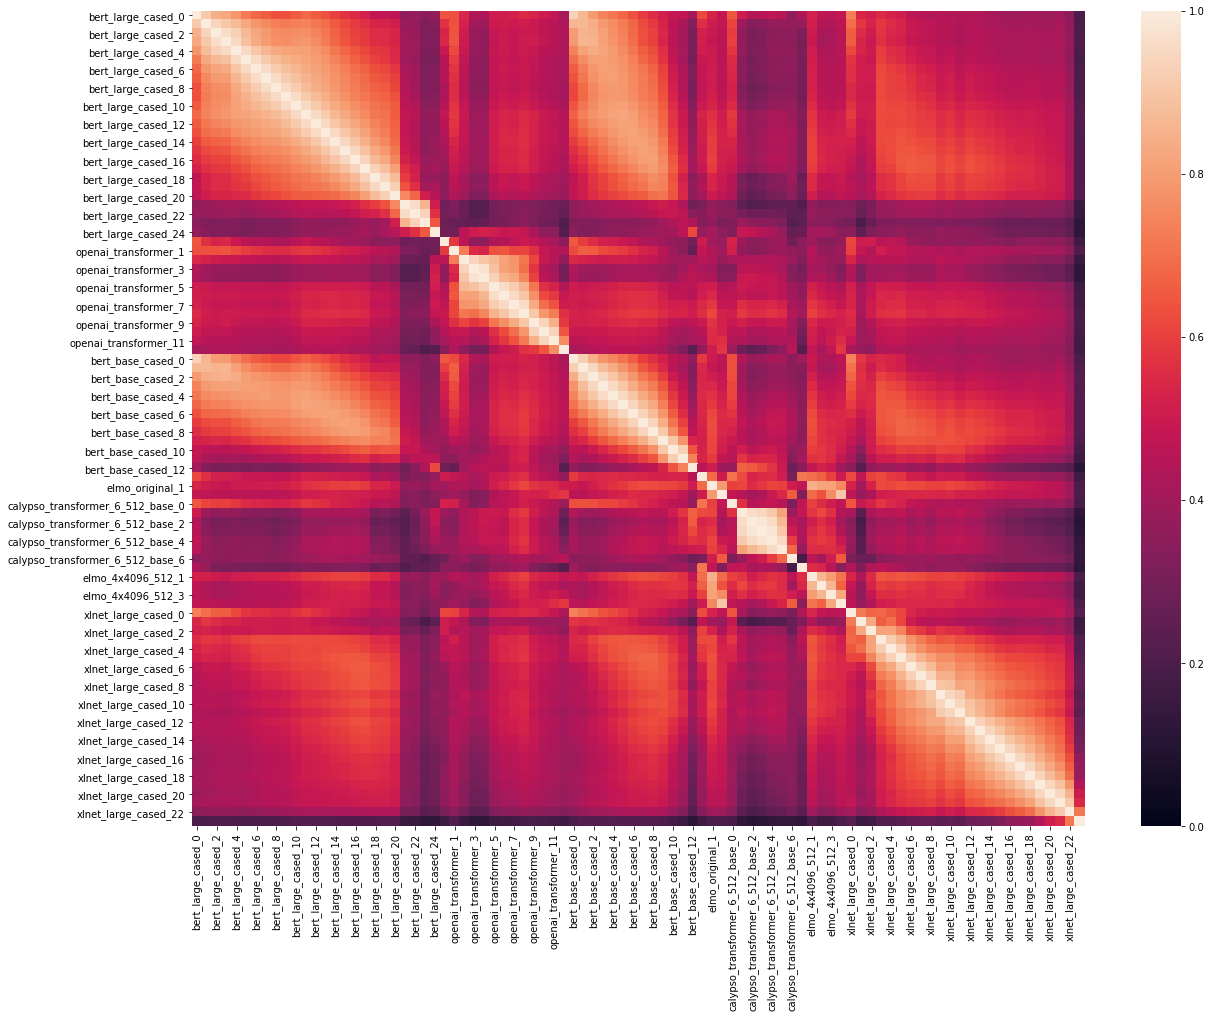

In [19]:
# lincka
sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1)

In [20]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        plt.imshow(fname)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname)
    
    plt.show()

In [21]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_pw_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [22]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_pw_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [23]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_maxmincorr_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [24]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_linregcorr_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [25]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [26]:
# comparing models
# use lincka
model1 = "elmo"
model2 = "elmo"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

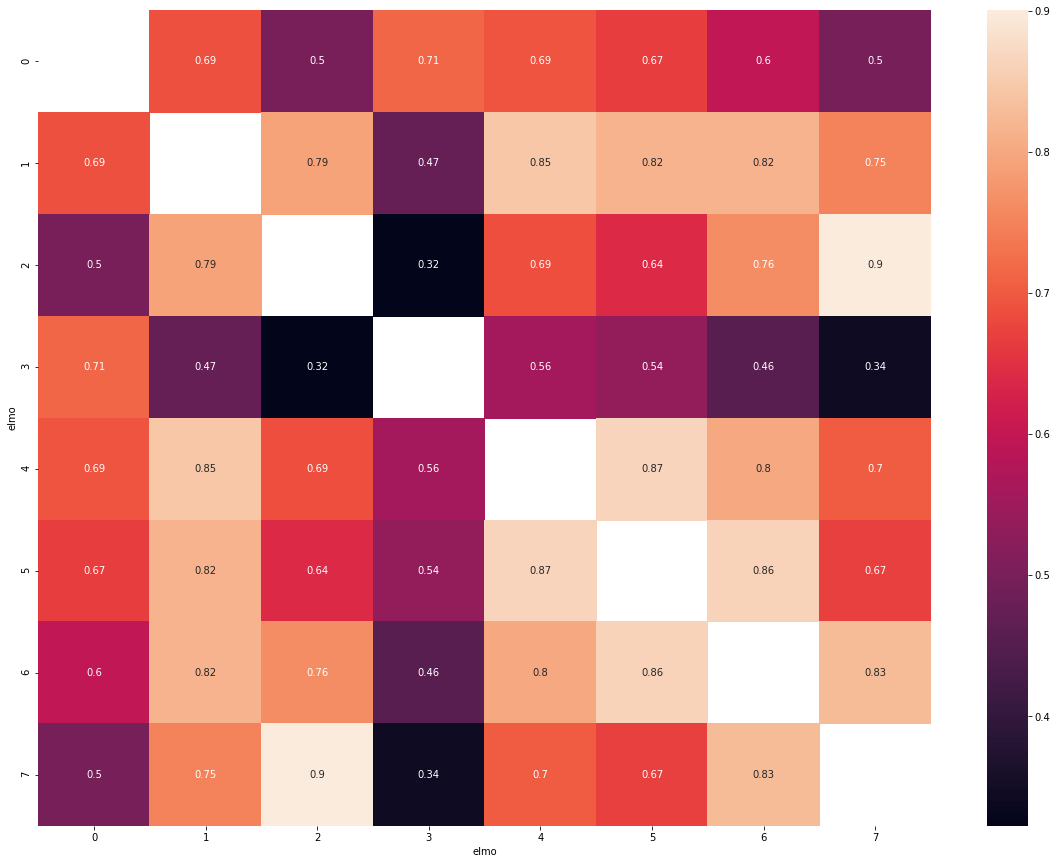

In [27]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()